# Importing the libraries

In [11]:
import numpy as np
import pandas as pd
from rdkit.Chem import MolFromSmiles, MolToSmiles

# Cleaning lipids data

In [45]:
from pandas import DataFrame
from rdkit.Chem import MolFromSmarts


def clean_lipids(df: DataFrame):
    lipid_like = []
    for i, row in df.iterrows():
        smiles = row['mols']

        mol = MolFromSmiles(smiles)

        smarts = MolFromSmarts("C~C~C~C~C~C~C~C~C~C")
        ring = MolFromSmarts("[R]")
        mol_sub1 = mol.GetSubstructMatch(smarts)
        mol_sub2 = mol.GetSubstructMatch(ring)
        if mol_sub1 and not mol_sub2:
            lipid_like.append(i)
    df.drop(lipid_like, inplace=True)
    return df


In [47]:
df = pd.read_csv("train_dataset.csv")
print(df.shape[0])
lipid_like = clean_lipids(df)
print(df.shape[0])
lipid_like.to_csv("train_dataset_w_lipids.csv", index=False)

8025
6803


In [48]:
df = pd.read_csv("test_dataset.csv")
print(df.shape[0])
lipid_like = clean_lipids(df)
print(df.shape[0])
lipid_like.to_csv("test_dataset_w_lipids.csv", index=False)

7705
6840


# Cleaning isomers

In [50]:



def clean_isomers(dataset):

    # Drop isomers from the same class
    sweet_molecules_list = []
    non_sweet_list = []
    to_drop = []
    for i, row in dataset.iterrows():
        smiles = row["mols"]
        sweet = row["y"]
        mol = MolFromSmiles(smiles)
        non_isomeric_smiles = MolToSmiles(mol, isomericSmiles=False)
        if sweet == 0:
            if non_isomeric_smiles not in non_sweet_list:
                non_sweet_list.append(non_isomeric_smiles)
            else:
                to_drop.append(i)
        else:
            if non_isomeric_smiles not in sweet_molecules_list:
                sweet_molecules_list.append(non_isomeric_smiles)
            else:
                to_drop.append(i)

    print(f"{len(to_drop)} dropped molecules with the same non-isomeric SMILES")
    dataset.drop(to_drop, inplace=True)

    # Drop isomers from different classes

    sweet_molecules = dataset[dataset["y"] == 1]
    non_sweet_molecules = dataset[dataset["y"] == 0]
    to_drop_sweet = []
    to_drop_non_sweet = []
    for i, row in sweet_molecules.iterrows():
        smiles = row["mols"]
        mol = MolFromSmiles(smiles)
        non_isomeric_smiles = MolToSmiles(mol, isomericSmiles=False)
        if non_isomeric_smiles in non_sweet_list:
            to_drop_sweet.append(i)
    sweet_molecules.drop(to_drop_sweet, inplace=True)

    for i, row in non_sweet_molecules.iterrows():
        smiles = row["mols"]
        mol = MolFromSmiles(smiles)
        non_isomeric_smiles = MolToSmiles(mol, isomericSmiles=False)
        if non_isomeric_smiles in sweet_molecules_list:
            to_drop_non_sweet.append(i)
    non_sweet_molecules.drop(to_drop_non_sweet, inplace=True)

    dataset = pd.concat([sweet_molecules, non_sweet_molecules])

    print(f"{len(to_drop_sweet)} dropped sweeteners with the same non-isomeric SMILES as non-sweeteners")
    print(f"{len(to_drop_non_sweet)} dropped non-sweeteners with the same non-isomeric SMILES as sweeteners")

    return dataset


def clean_isomers_in_test_and_train(train_dataset, test_dataset):
    non_isomeric_train = []
    for i, row in train_dataset.iterrows():
        smiles = row["mols"]
        mol = MolFromSmiles(smiles)
        non_isomeric_smiles = MolToSmiles(mol, isomericSmiles=False)
        non_isomeric_train.append(non_isomeric_smiles)

    to_drop = []
    for i, row in test_dataset.iterrows():
        smiles = row["mols"]
        mol = MolFromSmiles(smiles)
        non_isomeric_smiles = MolToSmiles(mol, isomericSmiles=False)
        if non_isomeric_smiles in non_isomeric_train:
            to_drop.append(i)

    test_dataset.drop(to_drop, inplace=True)
    print(f"{len(to_drop)} dropped molecules with the same non-isomeric SMILES in the test set and the train set")
    return train_dataset, test_dataset

In [56]:
train_dataset = pd.read_csv('train_dataset_w_lipids.csv')
train_dataset = clean_isomers(train_dataset)

1263 dropped molecules with the same non-isomeric SMILES


/home/joao/anaconda3/envs/DeepSweet/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


19 dropped sweeteners with the same non-isomeric SMILES as non-sweeteners
19 dropped non-sweeteners with the same non-isomeric SMILES as sweeteners


In [57]:
test_dataset = pd.read_csv('test_dataset_w_lipids.csv')
test_dataset = clean_isomers(test_dataset)
clean_isomers_in_test_and_train(train_dataset, test_dataset)

1283 dropped molecules with the same non-isomeric SMILES


/home/joao/anaconda3/envs/DeepSweet/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


18 dropped sweeteners with the same non-isomeric SMILES as non-sweeteners
18 dropped non-sweeteners with the same non-isomeric SMILES as sweeteners
851 dropped molecules with the same non-isomeric SMILES in the test set and the train set


(       ids                                         mols    y
 2824  2667                 COC(CO)COC1OC(CO)C(O)C(O)C1O  1.0
 2825  2669  CCCCOCC1OC(OC2C(CO)OC(O)C(O)C2O)C(O)C(O)C1O  1.0
 2826  2673                     O=CC(O)C(OCCO)C(O)C(O)CO  1.0
 2827  2665     OCC1OC(O)C(O)C(O)C1OC1OC(COO)C(O)C(O)C1O  1.0
 2828  2676       NC(=O)C(NC(=O)O)C(CCC1=CC=CC=C1)C(=O)O  1.0
 ...    ...                                          ...  ...
 2819  8017                             CC1=CC=C(CO)C=C1  0.0
 2820  8018                         CCC1=CC(C)=C(C)C=C1O  0.0
 2821  8022                              CCCC1=CC=CC=C1O  0.0
 2822  8023                            CCC1=CC=CC(O)=C1O  0.0
 2823  8021                          CCC1=C(C)C=C(C)C=C1  0.0
 
 [5502 rows x 3 columns],
        ids                                               mols    y
 2853  2671  CCCCCCCCOCC1(OC2OC(CO)C(O)C(O)C2O)OC(CO)C(OCCC...  1.0
 2854  2668                             CC(O)(O)C(O)C(O)C(O)CO  1.0
 2856  2664            C

In [58]:
train_dataset["y"].value_counts()

1.0    2801
0.0    2701
Name: y, dtype: int64

In [59]:
test_dataset["y"].value_counts()

0.0    2559
1.0    2111
Name: y, dtype: int64

# Cleaning from train set the data from other papers

In [60]:
from standardizer.CustomStandardizer import CustomStandardizer
from loaders.Loaders import CSVLoader


def standardize(dataset_file_path, label, smiles_field):

    loader = CSVLoader(dataset_file_path,
                       id_field = None,
                       mols_field=smiles_field,
                       labels_fields=label)

    dataset_to_test = loader.create_dataset()

    standardisation_params = {
        'REMOVE_ISOTOPE': True,
        'NEUTRALISE_CHARGE': True,
        'REMOVE_STEREO': False,
        'KEEP_BIGGEST': True,
        'ADD_HYDROGEN': False,
        'KEKULIZE': True,
        'NEUTRALISE_CHARGE_LATE': True}

    CustomStandardizer(params = standardisation_params).standardize(dataset_to_test)

    return dataset_to_test

def clean_from_train(dataset, paper_dataset, smiles_field):
    to_drop = []
    paper_non_isomeric_smiles = []

    paper_dataset = standardize(paper_dataset, "Sweet", smiles_field)

    for smiles in paper_dataset.mols:
        mol = MolFromSmiles(smiles)
        if mol is not None:
            non_isomeric_smiles = MolToSmiles(mol, isomericSmiles=False)
            paper_non_isomeric_smiles.append(non_isomeric_smiles)

    for i, row in dataset.iterrows():
        smiles = row["mols"]
        mol = MolFromSmiles(smiles)
        non_isomeric_smiles = MolToSmiles(mol, isomericSmiles=False)
        if non_isomeric_smiles in paper_non_isomeric_smiles:
            to_drop.append(i)
    dataset.drop(to_drop, inplace=True)
    print(f"{len(to_drop)} dropped molecules from the train set")
    return dataset

In [62]:
train_dataset = clean_from_train(train_dataset, "bittersweetforest-test.csv", "SMILES")

Standardizing datapoint 0


[10:56:56] Running Uncharger
[10:56:56] Running Uncharger
[10:56:56] Running Uncharger
[10:56:56] Running Uncharger
[10:56:56] Running Uncharger
[10:56:56] Running Uncharger
[10:56:56] Running Uncharger
[10:56:56] Running Uncharger
[10:56:56] Running Uncharger
[10:56:56] Running Uncharger
[10:56:56] Running Uncharger
[10:56:56] Running Uncharger
[10:56:56] Running Uncharger
[10:56:56] Running Uncharger
[10:56:56] Running Uncharger
[10:56:56] Running Uncharger
[10:56:56] Running Uncharger
[10:56:56] Running Uncharger
[10:56:56] Running Uncharger
[10:56:56] Running Uncharger
[10:56:56] Running Uncharger
[10:56:56] Running Uncharger
[10:56:56] Running Uncharger
[10:56:56] Running Uncharger
[10:56:56] Running Uncharger
[10:56:56] Running Uncharger
[10:56:56] Running Uncharger
[10:56:56] Running Uncharger
[10:56:56] Running Uncharger
[10:56:56] Running Uncharger
[10:56:56] Running Uncharger
[10:56:56] Running Uncharger
[10:56:56] Running Uncharger
[10:56:56] Running Uncharger
[10:56:56] Run

Python argument types in
    rdkit.Chem.rdmolops.Cleanup(str)
did not match C++ signature:
    Cleanup(RDKit::ROMol {lvalue} mol)
error in standardizing smile: BrCC[N](CC(=O)Nc1c(C)cccc1C)(C)C
Failed to featurize datapoint 102, BrCC[N](CC(=O)Nc1c(C)cccc1C)(C)C. Appending non standardized mol
Exception message: Python argument types in
    rdkit.Chem.rdmolfiles.MolToSmiles(str)
did not match C++ signature:
    MolToSmiles(RDKit::ROMol mol, bool isomericSmiles=True, bool kekuleSmiles=False, int rootedAtAtom=-1, bool canonical=True, bool allBondsExplicit=False, bool allHsExplicit=False, bool doRandom=False)
    MolToSmiles(RDKit::ROMol mol, RDKit::SmilesWriteParams params)
Python argument types in
    rdkit.Chem.rdmolops.Cleanup(str)
did not match C++ signature:
    Cleanup(RDKit::ROMol {lvalue} mol)
error in standardizing smile: CCCC[N](Cc1ccc(cc1)Cl)(CC(=O)Nc1c(C)cccc1C)C
Failed to featurize datapoint 103, CCCC[N](Cc1ccc(cc1)Cl)(CC(=O)Nc1c(C)cccc1C)C. Appending non standardized mol
Exce

[10:56:56] Explicit valence for atom # 8 N, 4, is greater than permitted
[10:56:56] Running Uncharger
[10:56:56] Running Uncharger
[10:56:56] Running Uncharger
[10:56:56] Running Uncharger
[10:56:56] Running Uncharger
[10:56:56] Running Uncharger
[10:56:56] Running Uncharger
[10:56:56] Running Uncharger
[10:56:56] Running Uncharger
[10:56:56] Running Uncharger
[10:56:56] Running Uncharger
[10:56:56] Running Uncharger
[10:56:56] Running Uncharger
[10:56:56] Running Uncharger
[10:56:56] Running Uncharger
[10:56:56] Running Uncharger
[10:56:56] Running Uncharger
[10:56:56] Running Uncharger
[10:56:56] Running Uncharger
[10:56:56] Running Uncharger
[10:56:56] Running Uncharger
[10:56:56] Running Uncharger
[10:56:56] Running Uncharger
[10:56:56] Running Uncharger
[10:56:56] Running Uncharger
[10:56:56] Running Uncharger
[10:56:56] Running Uncharger
[10:56:56] Running Uncharger
[10:56:56] Running Uncharger
[10:56:56] Running Uncharger
[10:56:56] Running Uncharger
[10:56:56] Running Uncharger

61 dropped molecules from the train set


In [63]:
train_dataset.to_csv("train_dataset_clean.csv", index=False)

In [64]:
test_dataset.to_csv("test_dataset_clean.csv", index=False)

In [76]:
train_dataset["y"].value_counts()

1.0    2749
0.0    2692
Name: y, dtype: int64

In [77]:
train_dataset.to_csv("clean_train_dataset_undersampled.csv", index=False)

# Undersample negative values

In [66]:
from rdkit import DataStructs
from rdkit.Chem import AllChem
from sklearn.manifold import TSNE

def generate_similarities(smiles):
    fps = []
    similarities_list = []
    for smiles in smiles:
        fp = AllChem.GetMorganFingerprintAsBitVect(MolFromSmiles(smiles), 2, 2048)
        fps.append(fp)

    if len(fps) > 10000:
        entries = 10000
    else:
        entries = len(fps)

    for i in range(0,entries):

        remaining_fp = fps[:i] + fps[i+1:]
        similarities = DataStructs.BulkTanimotoSimilarity(fps[i], remaining_fp)
        similarities.insert(i,1)
        similarities_list.append(similarities)

    return np.transpose(np.array(similarities_list))

def undersample_with_kmeans(dataset, final_number_of_samples):

    similarities = generate_similarities(dataset["mols"])

    from sklearn.manifold import TSNE
    # generate tSNE latent space of molecular similarities
    tsne_similarities = TSNE(n_components=2, random_state=123).fit_transform(similarities)
    from sklearn.cluster import KMeans
    import matplotlib.pyplot as plt

    kmeans = KMeans(n_clusters=10, random_state=123).fit(tsne_similarities)
    u_labels = np.unique(kmeans.labels_)
    plt.subplots(1, figsize=(25, 15))
    # plotting the results:
    centroids = kmeans.cluster_centers_
    for i in u_labels:
        plt.scatter(tsne_similarities[kmeans.labels_ == i, 0], tsne_similarities[kmeans.labels_ == i, 1], label=i, s=40)
    plt.scatter(centroids[:, 0], centroids[:, 1], s=80, color='k')
    plt.legend(prop={'size': 20})
    plt.title("K-means on t-SNE of tanimoto similarities", fontsize=25)
    plt.show()

    indexes_to_add = []
    for i in range(10):
        d = kmeans.transform(tsne_similarities)[:, i]
        inds = np.argsort(d)[::][:final_number_of_samples//9]
        for ind in inds:
            if ind not in indexes_to_add:
                indexes_to_add.append(ind)
    undersampled_dataset = dataset.iloc[indexes_to_add,:]

    return undersampled_dataset

/home/joao/anaconda3/envs/DeepSweet/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/joao/anaconda3/envs/DeepSweet/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


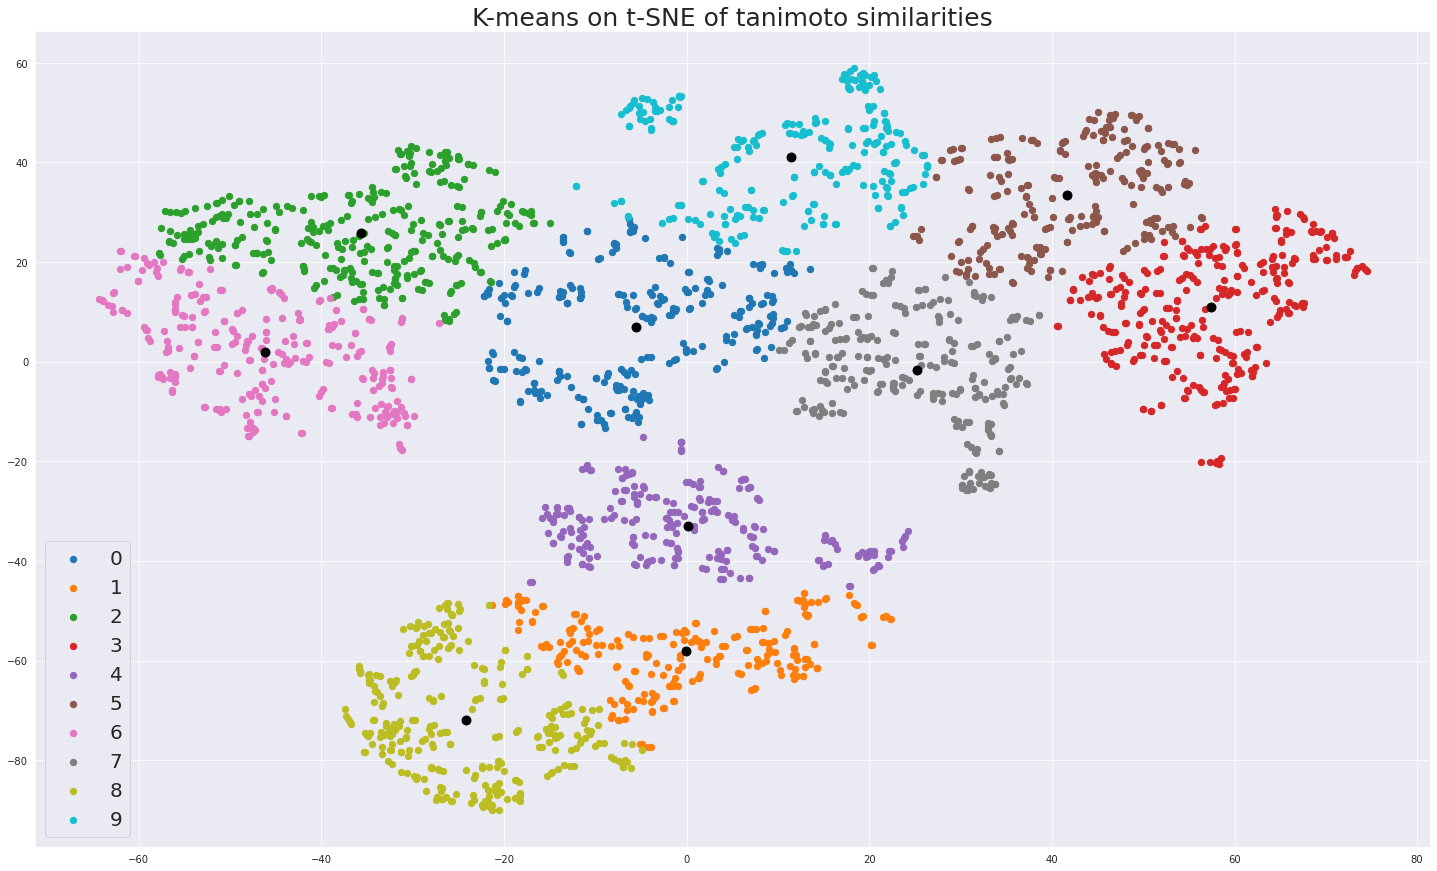

In [67]:
non_sweet_train = train_dataset[train_dataset["y"] == 0]
sweet_train = train_dataset[train_dataset["y"] == 1]
undersampled_dataset = undersample_with_kmeans(non_sweet_train, sweet_train.shape[0])

In [68]:
pd.concat([sweet_train, undersampled_dataset], ignore_index=True).to_csv("clean_train_dataset_undersampled.csv", index=False)

/home/joao/anaconda3/envs/DeepSweet/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/joao/anaconda3/envs/DeepSweet/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


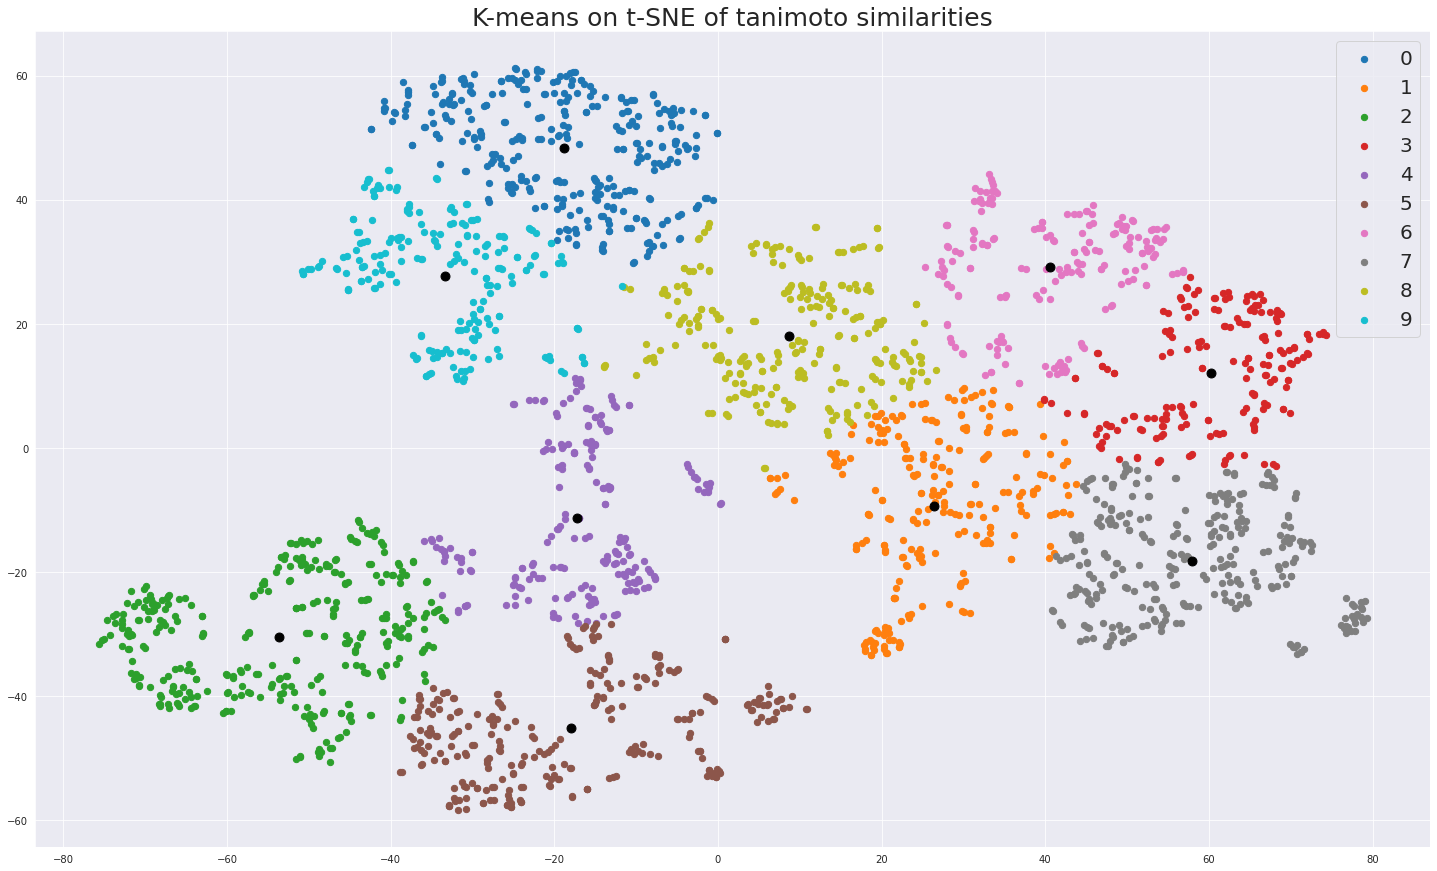

In [69]:
non_sweet_test = test_dataset[test_dataset["y"] == 0]
sweet_test = test_dataset[test_dataset["y"] == 1]
undersampled_dataset = undersample_with_kmeans(non_sweet_test, sweet_test.shape[0])

In [70]:
pd.concat([sweet_test, undersampled_dataset], ignore_index=True).to_csv("clean_test_dataset_undersampled.csv", index=False)

# Analysis of the train dataset and test dataset after cleaning

In [71]:
train_dataset = pd.read_csv("clean_train_dataset_undersampled.csv")
test_dataset = pd.read_csv("clean_test_dataset_undersampled.csv")

In [72]:
np.unique(train_dataset.mols)

array(['C#CC#CC(=O)C1=CC=CC=C1', 'C#CC#CC(O)CCOC1OC(CO)C(O)C(O)C1O',
       'C#CC#CCC1=CC=CC=C1', ...,
       '[N-]=[N+]=NOC[C@H]1O[C@@H](O[C@@H]2[C@@H](CO)O[C@H](O)[C@H](O)[C@H]2O)[C@H](O)[C@@H](O)[C@H]1O',
       '[NH3+][O-]', '[Sr+2]'], dtype=object)

In [78]:
test_dataset.y.value_counts()

0.0    2179
1.0    2111
Name: y, dtype: int64

In [82]:
def generate_similarity_tsne_by_class(dataset):

    import matplotlib.pyplot as plt
    import seaborn as sns

    similarities = generate_similarities(dataset["mols"])

    tsne_df = TSNE(n_components=2,random_state=123).fit_transform(similarities)

    labels = dataset.loc[:,"y"]

    string_labels = []
    for label in labels:
        if label == 1:
            string_labels.append("Sweet")
        else:
            string_labels.append("Not Sweet")
    fig, ax = plt.subplots()
    plt.figure(figsize=(15, 15))
    sns.scatterplot(
        tsne_df[:, 0], tsne_df[:, 1],
        hue=string_labels,
        palette=sns.color_palette("colorblind", 2),
        legend="full",
        s=25,
        ax=ax
    )

    ax.set_title("t-SNE of molecular similarities",
                           fontdict= { 'fontsize': 20 }, pad= 30)

    plt.setp(ax.get_legend().get_texts(), fontsize='15')
    ax.set_xticks(range(-150,150,10))
    ax.set_yticks(range(-150,150,10))
    fig.set_size_inches(15,15)
    ax.set_xlabel("t-SNE 1", fontsize='15')
    ax.set_ylabel("t-SNE 2", fontsize='15')
    plt.show()
    return tsne_df

/home/joao/anaconda3/envs/DeepSweet/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/joao/anaconda3/envs/DeepSweet/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/home/joao/anaconda3/envs/DeepSweet/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


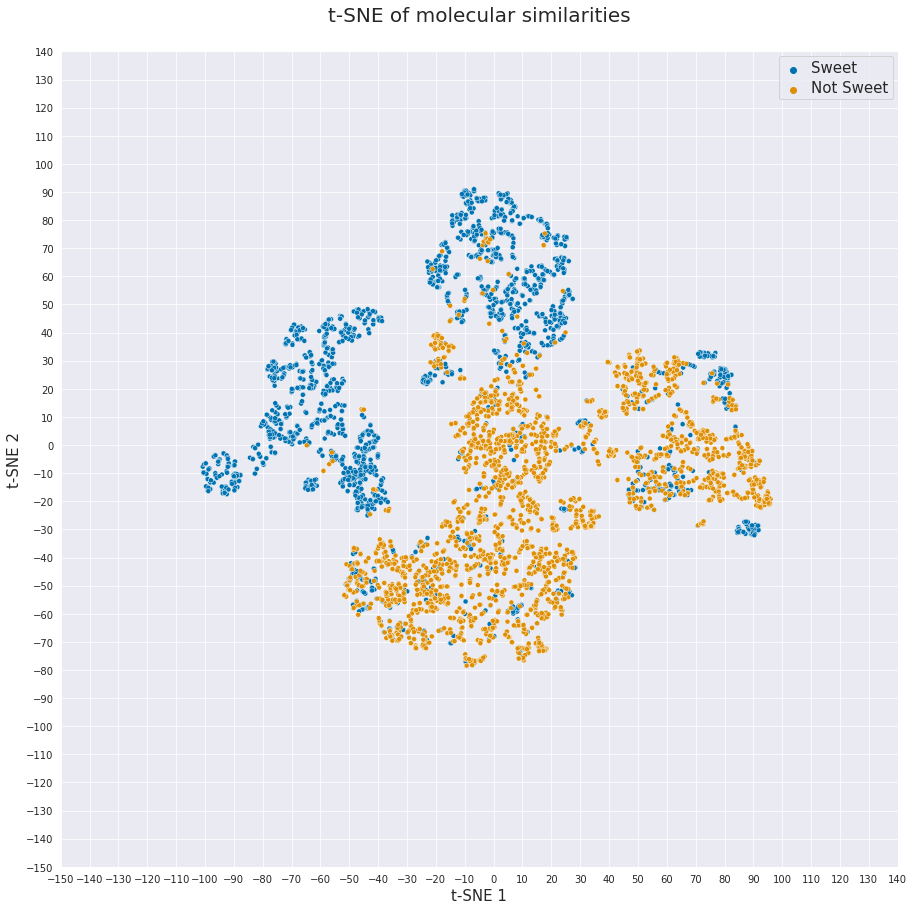

<Figure size 1080x1080 with 0 Axes>

In [83]:
tsne_df = generate_similarity_tsne_by_class(train_dataset)

In [85]:
region1 = []

for i in range(0,tsne_df.shape[0]):
    if tsne_df[i,0] > -150 and tsne_df[i,0] < -30 and tsne_df[i,1] > -30 and tsne_df[i,1] < 50:
        region1.append(i)

/home/joao/anaconda3/envs/DeepSweet/lib/python3.7/site-packages/rdkit/Chem/Draw/IPythonConsole.py:254: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  % (maxMols))


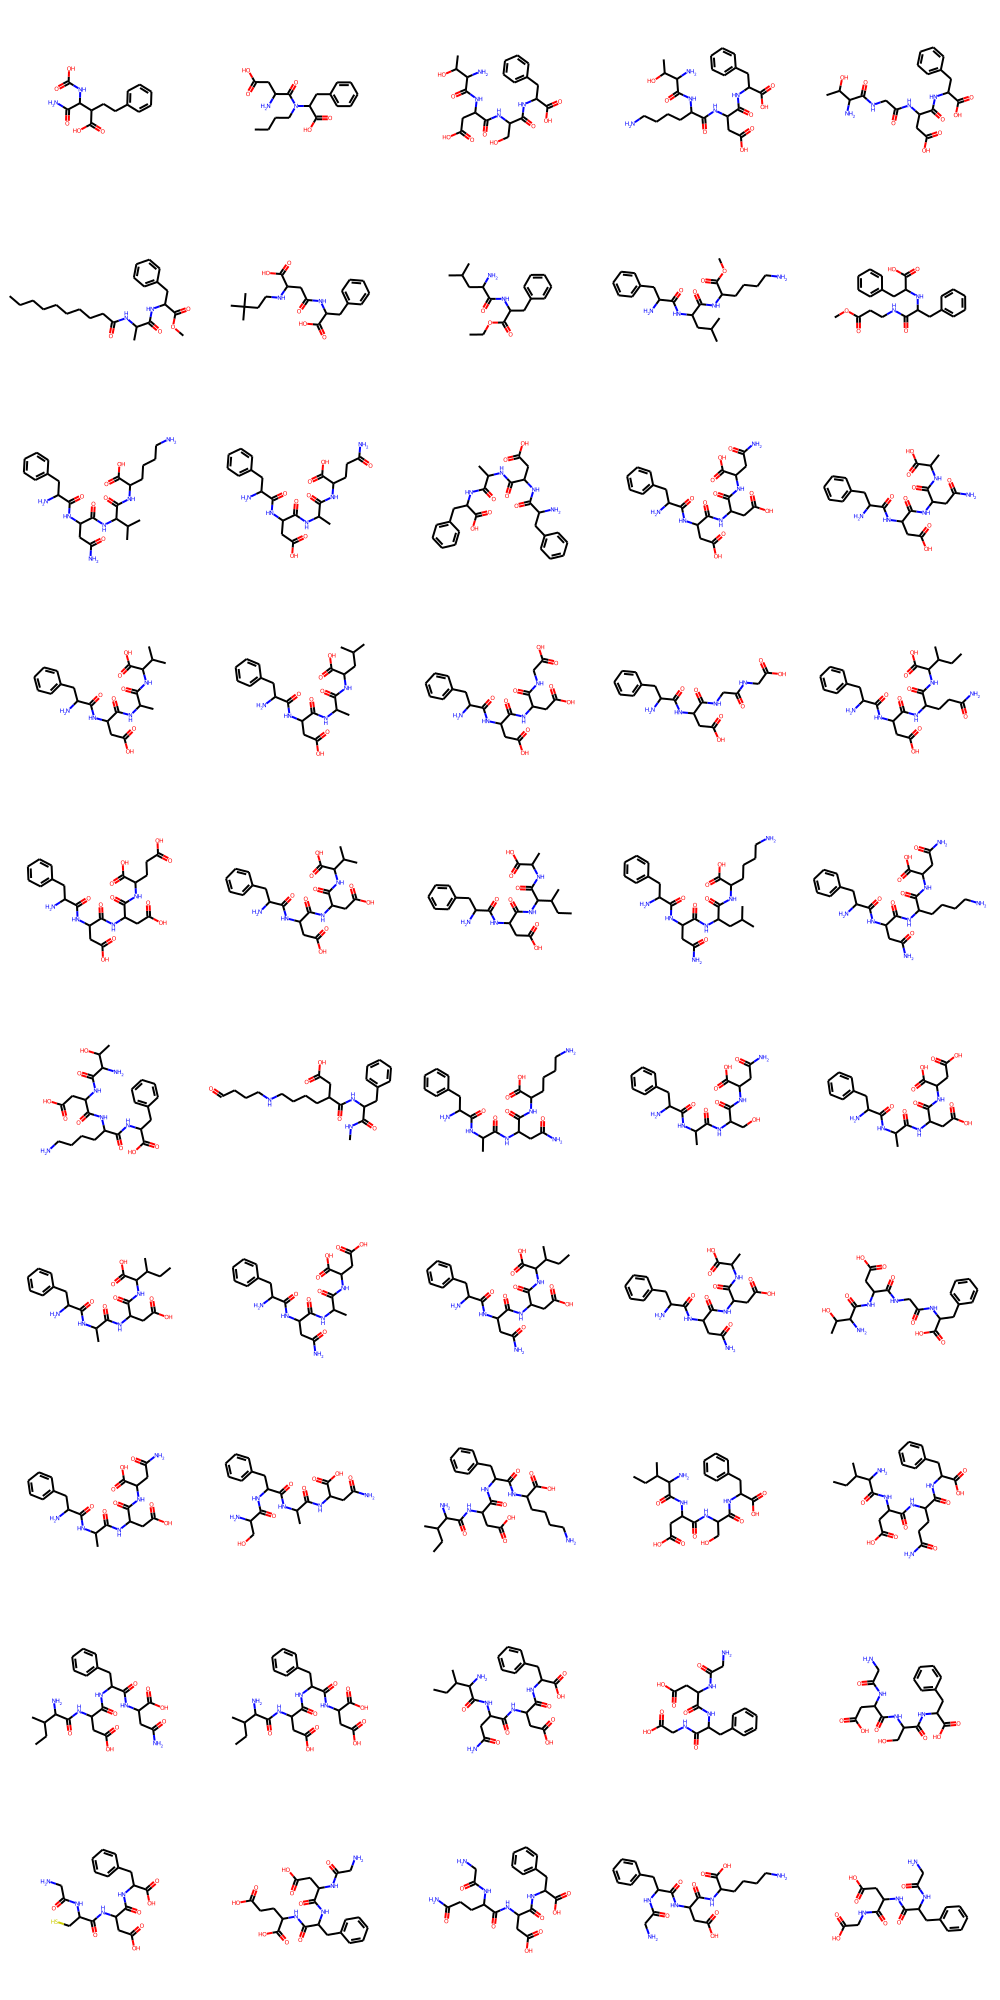

In [89]:
from rdkit.Chem import Draw

mols = [MolFromSmiles(smiles) for smiles in train_dataset.mols[region1].tolist()]

Draw.MolsToGridImage(mols,molsPerRow=5)

/home/joao/anaconda3/envs/DeepSweet/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/joao/anaconda3/envs/DeepSweet/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/home/joao/anaconda3/envs/DeepSweet/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


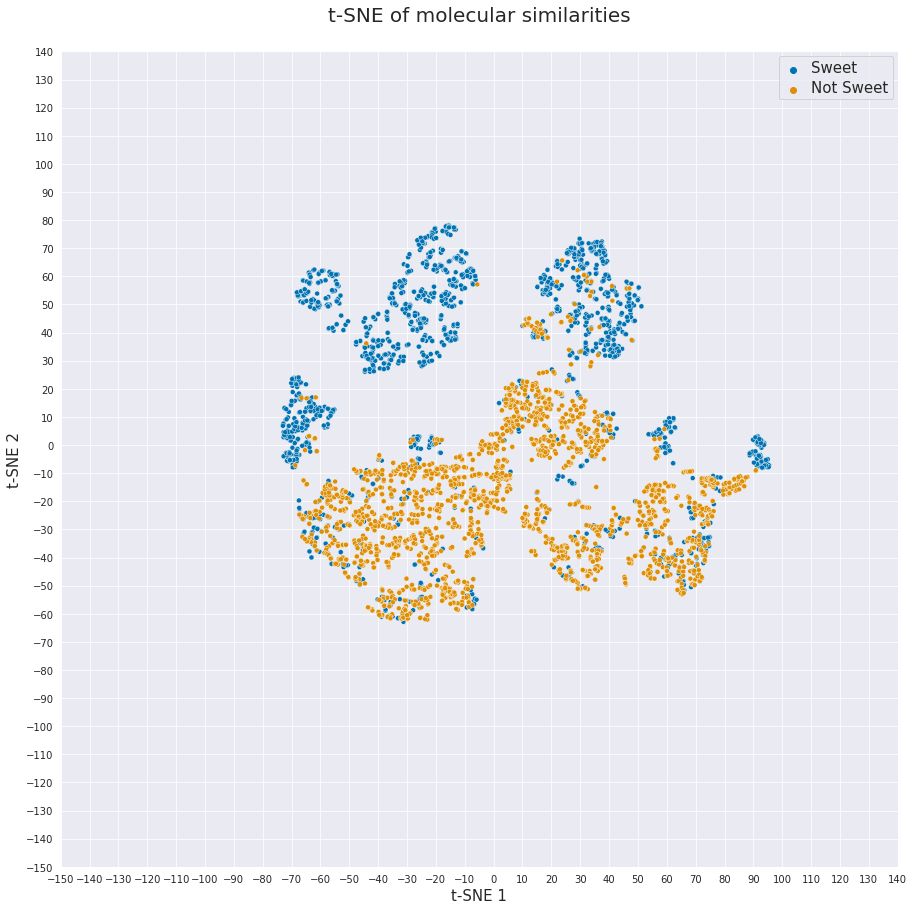

<Figure size 1080x1080 with 0 Axes>

In [90]:
tsne_df = generate_similarity_tsne_by_class(test_dataset)